# Univariate ARIMA Models

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1396.579
Date:                Sat, 29 Mar 2025   AIC                           2799.159
Time:                        23:13:32   BIC                           2813.879
Sample:                             0   HQIC                          2804.754
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0433      4.905      0.009      0.993      -9.570       9.656
ma.L1         -0.0501      4.904     -0.010      0.992      -9.662       9.562
sigma2         0.9587      0.042     22.587      0.0

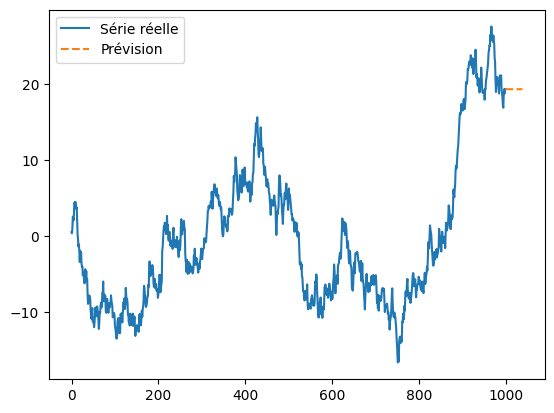

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Générer une série temporelle artificielle
np.random.seed(42)
n = 1000
y = np.cumsum(np.random.randn(n))  # Processus non stationnaire (somme de bruit blanc)

# Ajuster un modèle ARIMA(1,1,1)
model = ARIMA(y, order=(1, 1, 1))
result = model.fit()

# Afficher le résumé du modèle
print(result.summary())

# Faire des prévisions
forecast = result.forecast(steps=40)
plt.plot(y, label="Série réelle")
plt.plot(range(n, n+40), forecast, label="Prévision", linestyle="dashed")
plt.legend()
plt.show()


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from tqdm import tqdm
from itertools import product
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')

In [4]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

## Download Series

Load monthly industrial production and daily NASDAQ stock market index:

In [5]:
industrial_production = web.DataReader('IPGMFN', 'fred', '1988', '2017-12').squeeze().dropna()
nasdaq = web.DataReader('NASDAQCOM', 'fred', '1990', '2017-12-31').squeeze().dropna()

### Log Transformation

In [6]:
nasdaq_log = np.log(nasdaq)
industrial_production_log = np.log(industrial_production)

### Differencing

In [7]:
nasdaq_log_diff = nasdaq_log.diff().dropna()

# seasonal differencing => yoy instantanteous returns
industrial_production_log_diff = industrial_production_log.diff(12).dropna()

## Univariate Time Series Models

### Autoregressive (AR) Model

Multiple linear-regression models expressed the variable of interest as a linear combination of predictors or input variables. Univariate time series models relate the value of the time series at the point in time of interest to a linear combination of lagged values of the series and possibly past disturbance terms.
While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data. ARIMA(p, d, q) models require stationarity and leverage two building blocks:
- Autoregressive (AR) terms consisting of p-lagged values of the time series
- Moving average (MA) terms that contain q-lagged disturbances


Chapter 8 introduces the ARIMA building blocks, simple autoregressive (AR) and moving average (MA) models, and explains how to combine them in autoregressive moving-average (ARMA) models that may account for series integration as ARIMA models or include exogenous variables as AR(I)MAX models. 

Furthermore, we will illustrate how to include seasonal AR and MA terms to extend the toolbox to also include SARMAX models.

### ARMA vs ARIMA

The ARMA model of the undifferenced series produces the same result as the ARIMA model of the differenced series.

In [8]:
model1 = tsa.ARMA(endog=nasdaq_log_diff, order=(2,2)).fit()
model2 = tsa.ARIMA(endog=nasdaq_log, order=(2,1,2)).fit()

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [9]:
model1.params.sort_index() == model2.params.sort_index().values

ar.L1.NASDAQCOM    True
ar.L2.NASDAQCOM    True
const              True
ma.L1.NASDAQCOM    True
ma.L2.NASDAQCOM    True
dtype: bool

### Seasonal differencing vs SARIMAX

Seasonal differencing has same effect as using SARIMAX w seasonal order (0,1,0,12).

In [10]:
model1 = tsa.statespace.SARIMAX(industrial_production_log, order=(2,0,2), seasonal_order=(0,1,0,12)).fit()
model2 = tsa.statespace.SARIMAX(industrial_production_log_diff, order=(2,0,2), seasonal_order=(0,0,0,12)).fit()

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will 

In [11]:
model1.params.to_frame('SARIMAX').join(model2.params.to_frame('diff'))

,SARIMAX,diff
ar.L1,1.765901,1.765978
ar.L2,-0.788175,-0.788255
ma.L1,-0.859266,-0.859608
ma.L2,0.352755,0.353158
sigma2,0.000101,0.000101


## Finding the optimal ARMA lags

### Run candidate models

We iterate over various (p, q) lag combinations and collect diagnostic statistics to compare the result.

In [12]:
train_size = 120
results = {}
y_true = industrial_production_log_diff.iloc[train_size:]
for p in range(5):
    for q in range(5):
        aic, bic = [], []
        if p == 0 and q == 0:
            continue
        print(p, q)
        convergence_error = stationarity_error = 0
        y_pred = []
        for T in range(train_size, len(industrial_production_log_diff)):
            train_set = industrial_production_log_diff.iloc[T-train_size:T]
            try:
                model = tsa.ARMA(endog=train_set, order=(p, q)).fit()
            except LinAlgError:
                convergence_error += 1
            except ValueError:
                stationarity_error += 1

            forecast, _, _ = model.forecast(steps=1)
            y_pred.append(forecast[0])
            aic.append(model.aic)
            bic.append(model.bic)

        result = (pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
                  .replace(np.inf, np.nan)
                  .dropna())

        rmse = np.sqrt(mean_squared_error(
            y_true=result.y_true, y_pred=result.y_pred))

        results[(p, q)] = [rmse,
                           np.mean(aic),
                           np.mean(bic),
                           convergence_error,
                           stationarity_error]

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


0 1


/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be 

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

0 2


/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

0 3


/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be 

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

0 4


/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be 

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

1 0


/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

1 1


/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

1 2


/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/home/stefan/.pyenv/versions/miniconda3-latest/envs/ml4t/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be u

KeyboardInterrupt: 

In [ ]:
arma_results = pd.DataFrame(results).T
arma_results.columns = ['RMSE', 'AIC', 'BIC', 'convergence', 'stationarity']
arma_results.index.names = ['p', 'q']
arma_results.info()

In [ ]:
with pd.HDFStore('arima.h5') as store:
    store.put('arma', arma_results)

We aim to minimize both RMSE and BIC:

In [ ]:
arma_results.nsmallest(5, columns=['RMSE'])

In [ ]:
arma_results.nsmallest(5, columns=['BIC'])

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharex=True, sharey=True)
sns.heatmap(arma_results[arma_results.RMSE<.5].RMSE.unstack().mul(10), fmt='.3f', annot=True, cmap='Blues', ax=axes[0], cbar=False);
sns.heatmap(arma_results.BIC.unstack(), fmt='.2f', annot=True, cmap='Blues', ax=axes[1], cbar=False)
axes[0].set_title('Root Mean Squared Error')
axes[1].set_title('Bayesian Information Criterion')
fig.tight_layout();

In [ ]:
arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).nsmallest(5)

### Estimating the best ARMA Model

ARMA(4,0) and ARMA(4,1) are close, so we chose the more parsimonious (4,0) configuration:

In [ ]:
best_p, best_q = arma_results.rank().loc[:, ['RMSE', 'BIC']].mean(1).idxmin()

In [ ]:
best_arma_model = tsa.ARMA(endog=industrial_production_log_diff, order=(best_p, best_q)).fit()
print(best_arma_model.summary())

### Check Residual Correlogram

In [ ]:
plot_correlogram(best_arma_model.resid)

## SARIMAX

In [ ]:
sarimax_model = tsa.SARIMAX(endog=industrial_production_log_diff.dropna().values,
                    order=(2, 0, 2),
                    seasonal_order=(1, 0, 1, 12)).fit(start_params=[0, 0, 0, 0, 0, 0, 1])

In [ ]:
print(sarimax_model.summary())

In [ ]:
plot_correlogram(pd.Series(sarimax_model.resid))

We will build a SARIMAX model for monthly data on an industrial production time series for the 1988-2017 period. As illustrated in the first section on analytical tools, the data has been log-transformed, and we are using seasonal (lag-12) differences. We estimate the model for a range of both ordinary and conventional AR and MA parameters using a rolling window of 10 years of training data, and evaluate the RMSE of the 1-step-ahead forecast.

### Finding the optimal number of lags

This takes a while...

In [ ]:
l3 = list(range(3))
l4 = list(range(4))
params = [t for t in product(l4, l4, l3, l3) if t[0] > 0 and t[1] >  0]
len(params)

In [ ]:
train_size = 120 # 10 years of training data
results = {}
test_set = industrial_production_log_diff.iloc[train_size:]

for p1, q1, p2, q2 in tqdm(params):
    preds = test_set.copy().to_frame('y_true').assign(y_pred=np.nan)
    aic, bic = [], []
    if p1 == 0 and q1 == 0:
        continue
    convergence_error = stationarity_error = 0
    y_pred = []
    for i, T in enumerate(range(train_size, len(industrial_production_log_diff))):
        train_set = industrial_production_log_diff.iloc[T-train_size:T]
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                model = tsa.SARIMAX(endog=train_set.values,
                                order=(p1, 0, q1),
                                seasonal_order=(p2, 0, q2, 12)).fit(disp=0)
        except LinAlgError:
            convergence_error += 1
        except ValueError:
            stationarity_error += 1

        preds.iloc[i, 1] = model.forecast(steps=1)[0]
        aic.append(model.aic)
        bic.append(model.bic)

    preds.dropna(inplace=True)
    mse = mean_squared_error(preds.y_true, preds.y_pred)
    results[(p1, q1, p2, q2)] = [np.sqrt(mse),
                                      preds.y_true.sub(preds.y_pred).pow(2).std(),
                                      np.mean(aic),
                                      np.std(aic),                                                  
                                      np.mean(bic),
                                      np.std(bic),                                                  
                                      convergence_error,
                                      stationarity_error]

### Compare model metrics

In [ ]:
sarimax_results = pd.DataFrame(results).T
sarimax_results.columns = ['RMSE', 'RMSE_std', 'AIC', 'AIC_std', 'BIC', 'BIC_std', 'convergence', 'stationarity']
sarimax_results['CV'] = sarimax_results.RMSE_std.div(sarimax_results.RMSE)
sarimax_results.index.names = ['p1', 'q1', 'p2', 'q2']
sarimax_results.info()

In [ ]:
with pd.HDFStore('arima.h5') as store:
    store.put('sarimax', sarimax_results)

In [ ]:
with pd.HDFStore('arima.h5') as store:
    sarimax_results = store.get('sarimax')

In [ ]:
sarimax_results.nsmallest(5, columns='RMSE')

We also collect the AIC and BIC criteria that show a very high rank correlation coefficient of 0.94, with BIC favoring models with slightly fewer parameters than AIC. The best five models by RMSE are:

In [ ]:
sarimax_results[['RMSE', 'AIC', 'BIC']].sort_values('RMSE').head()

In [ ]:
sarimax_results[['RMSE', 'AIC', 'BIC']].corr('spearman')

In [ ]:
sns.jointplot(y='RMSE', x='BIC', data=sarimax_results[['RMSE', 'BIC']].rank());

In [ ]:
sarimax_results[(sarimax_results.RMSE < sarimax_results.RMSE.quantile(.05)) &
                (sarimax_results.BIC < sarimax_results.BIC.quantile(.1))].sort_values('RMSE')

### Train best model

In [ ]:
p1, q1, p2, q2 = 2, 3, 1, 2

In [ ]:
best_model = tsa.SARIMAX(endog=industrial_production_log_diff.values, order=(p1, 0, q1),
                         seasonal_order=(p2, 0, q2, 12)).fit()

In [ ]:
print(best_model.summary())

### Check Residual Correlogram

In [ ]:
plot_correlogram(pd.Series(best_model.resid),
                 lags=20,
                 title=f'SARIMAX ({p1}, 0, {q1}) x ({p2}, 0, {q2}, 12) | Model Diagnostics')